# **🌟 Xception Model**

- Xception Model is proposed by Francois Chollet. 
- Xception is an extension of the inception Architecture which replaces the standard Inception modules with depthwise Separable Convolutions.

![Xception Model](./snapshots/architecture.webp)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from PIL import Image
from tqdm import tqdm
import seaborn as sns
import cv2

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential 
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.xception import preprocess_input, decode_predictions

2023-09-17 19:14:37.854627: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-17 19:14:39.508719: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## About the Data Set

This [dataset] contains 25,000 histopathological images with 5 classes. All images are 768 x 768 pixels in size and are in jpeg file format. The images were generated from an original sample of HIPAA compliant and validated sources, consisting of 750 total images of lung tissue (250 benign lung tissue, 250 lung adenocarcinomas, and 250 lung squamous cell carcinomas) and 500 total images of colon tissue (250 benign colon tissue and 250 colon adenocarcinomas) and augmented to 25,000 using the Augmentor package.

There are five classes in the dataset, each with 5,000 images, being:

 1. Lung benign tissue
 2. Lung adenocarcinoma
 3. Lung squamous cell carcinoma
 4. Colon adenocarcinoma
 5. Colon benign tissue

[dataset]:https://www.kaggle.com/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images

In [2]:
IMAGE_PATH="./images/"

classes = {
    "lung_aca": IMAGE_PATH + "lung_image_sets/lung_aca/",
    "lung_n": IMAGE_PATH + "lung_image_sets/lung_n/", 
    "lung_scc": IMAGE_PATH + "lung_image_sets/lung_scc/", 
    "colon_aca": IMAGE_PATH + "colon_image_sets/colon_aca/", 
    "colon_n": IMAGE_PATH + "colon_image_sets/colon_n/"
}

In [3]:
data = [(class_name, image_path + relative_image_path) for class_name, image_path in classes.items() for relative_image_path in os.listdir(image_path)]


In [4]:
len(data)

25000

In [5]:
data[:10]

[('lung_aca', './images/lung_image_sets/lung_aca/lungaca4529.jpeg'),
 ('lung_aca', './images/lung_image_sets/lung_aca/lungaca277.jpeg'),
 ('lung_aca', './images/lung_image_sets/lung_aca/lungaca3452.jpeg'),
 ('lung_aca', './images/lung_image_sets/lung_aca/lungaca652.jpeg'),
 ('lung_aca', './images/lung_image_sets/lung_aca/lungaca993.jpeg'),
 ('lung_aca', './images/lung_image_sets/lung_aca/lungaca4082.jpeg'),
 ('lung_aca', './images/lung_image_sets/lung_aca/lungaca123.jpeg'),
 ('lung_aca', './images/lung_image_sets/lung_aca/lungaca294.jpeg'),
 ('lung_aca', './images/lung_image_sets/lung_aca/lungaca3174.jpeg'),
 ('lung_aca', './images/lung_image_sets/lung_aca/lungaca2601.jpeg')]

In [6]:
width, height = Image.open(data[0][1]).size
print(f"width: {width} and height: {height} are dimensions of the image.")

width: 768 and height: 768 are dimensions of the image.


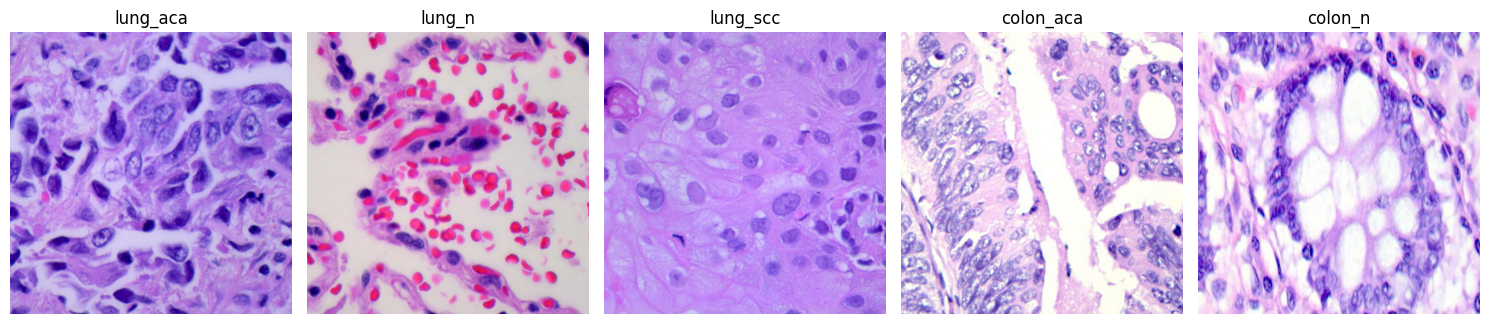

In [7]:
num_rows = 1
num_cols = len(classes)
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5))

for idx, (class_name, image_path) in enumerate(classes.items()):
    image_files = os.listdir(image_path)
    
    if image_files:
        image_file = os.path.join(image_path, image_files[0])
        img = Image.open(image_file)
        
        if num_cols == 1:
            axes.imshow(img)
            axes.set_title(class_name)
        else:
            ax = axes[idx]
            ax.imshow(img)
            ax.set_title(class_name)
        
        ax.axis('off')

plt.tight_layout()

plt.show()

## **Limiting GPU Memory Growth**

In [3]:
def limitgpu(maxmem):
	gpus = tf.config.list_physical_devices('GPU')
	if gpus:
		# Restrict TensorFlow to only allocate a fraction of GPU memory
		try:
			for gpu in gpus:
				tf.config.experimental.set_virtual_device_configuration(gpu,
						[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=maxmem)])
				print("ok")
		except RuntimeError as e:
			# Virtual devices must be set before GPUs have been initialized
			print(e)


# 1.5GB
limitgpu(1024*5) 

ok


2023-09-17 19:14:46.016417: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-17 19:14:46.192719: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-17 19:14:46.193371: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [4]:
num_classes=5

model = Sequential()
model.add(Xception(weights='imagenet', include_top=False, input_shape=(299, 299, 3)))
model.add(GlobalAveragePooling2D())
# model.add(Dense(2048, activation='relu'))
model.add(Dense(500, activation='relu'))
# model.add(Dense(1024, activation='relu'))
# model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='sigmoid'))
model.layers[0].trainable=False             
model.summary()

2023-09-17 19:14:47.906384: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-17 19:14:47.906835: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-17 19:14:47.907111: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 500)               1024500   
                                                                 
 dense_1 (Dense)             (None, 5)                 2505      
                                                                 
Total params: 21888485 (83.50 MB)
Trainable params: 1027005 (3.92 MB)
Non-trainable params: 20861480 (79.58 MB)
_________________________________________________________________


In [5]:
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
X = [image_path for class_name, image_path in data]
y = [class_name for class_name, image_path in data]

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
f"X_train: {len(X_train)}, X_test: {len(X_test)}, y_train: {len(y_train)}, y_test: {len(y_test)}"

'X_train: 20000, X_test: 5000, y_train: 20000, y_test: 5000'

In [14]:
processed_X_train = []

for image_path in tqdm(X_train[:4100], desc="image "):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(299, 299))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = preprocess_input(img)
    processed_X_train.append(img)


image : 100%|██████████| 4100/4100 [00:31<00:00, 131.48it/s]


In [15]:
processed_X_train = np.array(processed_X_train)

In [16]:
processed_X_train.shape

(4100, 299, 299, 3)

In [17]:
label_encoder = LabelEncoder()

In [18]:
y_train_encoded = label_encoder.fit_transform(y_train[:4100])

In [19]:
y_train_tensor = np.array(y_train_encoded)

In [20]:
y_train_tensor = to_categorical(y_train_encoded, num_classes = 5)

In [21]:
y_train_tensor

array([[0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.]], dtype=float32)

In [22]:
len(y_train_tensor), len(processed_X_train)

(4100, 4100)

In [23]:
model.fit(
    processed_X_train,
    y_train_tensor,
    epochs=10,  
    batch_size=10,  
    validation_split=0.2
)

2023-09-17 18:39:49.224764: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 3518823360 exceeds 10% of free system memory.


Epoch 1/10


2023-09-17 18:40:01.982500: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8904
2023-09-17 18:40:04.253312: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.18GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-09-17 18:40:05.141386: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fce97323580 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-09-17 18:40:05.141425: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5
2023-09-17 18:40:05.261344: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-09-17 18:40:05.729760: I ./tensorflow/com

328/328 [==============================] - ETA: 0s - loss: 0.2261 - accuracy: 0.9143

2023-09-17 18:40:38.585173: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 128.00MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-09-17 18:40:38.591982: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 128.00MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-09-17 18:40:38.646383: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 128.00MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-09-17 18:40:38.646516: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocato

328/328 [==============================] - 50s 115ms/step - loss: 0.2261 - accuracy: 0.9143 - val_loss: 0.1026 - val_accuracy: 0.9671
Epoch 2/10
328/328 [==============================] - 27s 82ms/step - loss: 0.0845 - accuracy: 0.9677 - val_loss: 0.0725 - val_accuracy: 0.9695
Epoch 3/10
328/328 [==============================] - 27s 83ms/step - loss: 0.0575 - accuracy: 0.9799 - val_loss: 0.0590 - val_accuracy: 0.9744
Epoch 4/10
328/328 [==============================] - 27s 83ms/step - loss: 0.0473 - accuracy: 0.9832 - val_loss: 0.0446 - val_accuracy: 0.9841
Epoch 5/10
328/328 [==============================] - 28s 84ms/step - loss: 0.0545 - accuracy: 0.9787 - val_loss: 0.0565 - val_accuracy: 0.9793
Epoch 6/10
328/328 [==============================] - 28s 85ms/step - loss: 0.0295 - accuracy: 0.9899 - val_loss: 0.0409 - val_accuracy: 0.9878
Epoch 7/10
328/328 [==============================] - 28s 85ms/step - loss: 0.0280 - accuracy: 0.9905 - val_loss: 0.0533 - val_accuracy: 0.9841
Ep

## **Saving Model Metadata**

In [24]:
history_data = model.history.history
history_df = pd.DataFrame(history_data)
history_df.to_csv('training_history_xception.csv', index=False)

## **Plotting Model Perfomance**

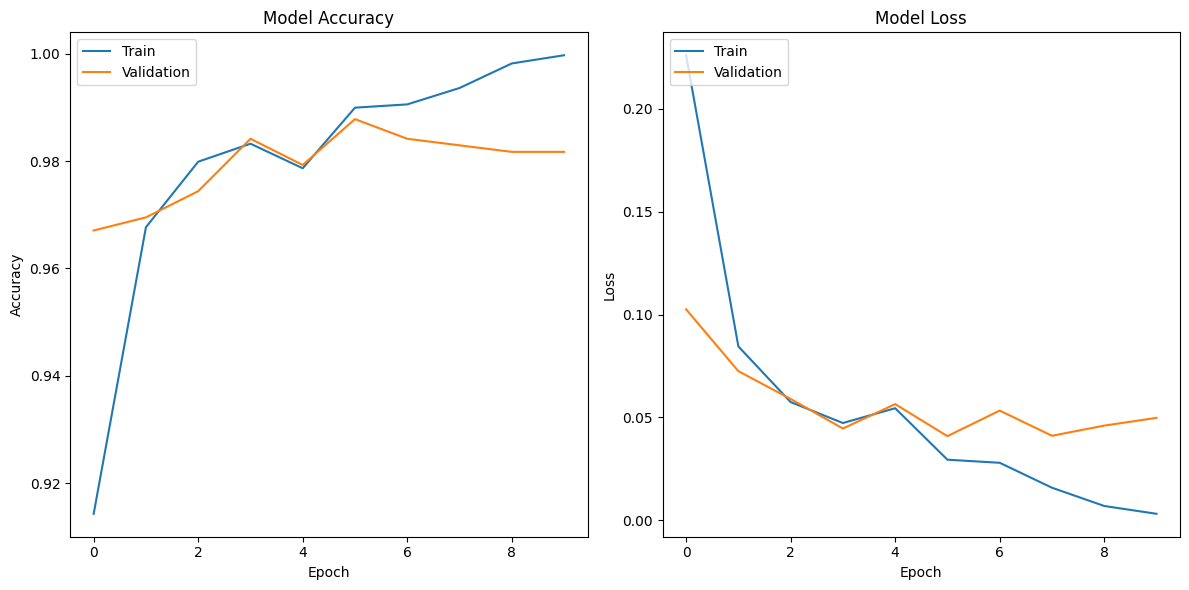

In [25]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

## Predicting

In [43]:
processed_X_test = []

for image_path in tqdm(X_test[:1500], desc="image "):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(299, 299))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = preprocess_input(img)
    processed_X_test.append(img)

image : 100%|██████████| 1500/1500 [00:20<00:00, 73.05it/s] 


In [44]:
processed_X_test = np.array(processed_X_test)

In [45]:
y_test_encoded = label_encoder.transform(y_test[:1500])

In [46]:
y_test_encoded_to = to_categorical(y_test_encoded, num_classes=5)

## **Saving processed as numpy**

In [47]:
np.save('processed_X_test.npy', processed_X_test)

In [32]:
np.save('processed_X_train.npy', processed_X_train)

In [48]:
np.save('y_test_encoded_to.npy', y_test_encoded_to)

In [37]:
np.save('y_train_tensor.npy', y_train_tensor)

In [41]:
# del y_train_tensor
# del processed_X_train

## **Loading npy**

In [7]:
processed_X_test = np.load("processed_X_test.npy")

In [8]:
y_test_encoded_to = np.load("y_test_encoded_to.npy")

In [ ]:
processed_X_test = np.load("processed_X_test.npy")

In [13]:
y_train_tensor = np.load("y_train_tensor.npy")

## **Saving Model**

In [50]:
model.save_weights('custom_xception.h5')

## **Loading Model**

In [6]:
model.load_weights('custom_xception.h5')

## **Predicting**

In [9]:
predictions = model.predict(processed_X_test)

2023-09-17 19:16:39.446699: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1609218000 exceeds 10% of free system memory.
2023-09-17 19:16:41.257301: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1609218000 exceeds 10% of free system memory.
2023-09-17 19:16:45.774132: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8904


47/47 [==============================] - 18s 241ms/step


In [10]:
predicted_labels = np.argmax(predictions, axis=1)

In [19]:
predicted_labels_to = to_categorical(predicted_labels, num_classes = 5)

In [22]:
correctly_classified = np.sum(predicted_labels_to == y_test_encoded_to)
total_samples = len(y_test_encoded_to)
accuracy = correctly_classified / total_samples
misclassified_indices = np.where(predicted_labels_to != y_test_encoded_to)[0]

In [25]:
f"Accuracy : {accuracy * 100}"

'Accuracy : 98.25'

In [ ]:
misclassified_indices

array([ 122,  331,  370,  447,  500,  529,  631,  633,  684,  913,  940,
        948,  963, 1008, 1064, 1087, 1125, 1262, 1291, 1304, 1332, 1391,
       1495, 1504, 1561, 1594, 1654, 1671, 1704, 1728, 1751, 1869, 1871,
       1941, 1984, 2002, 2132, 2198, 2309, 2380, 2418])

## **Confusion Matrix**

In [75]:
confusion = confusion_matrix(y_test_encoded, predicted_labels)
print(confusion)

[[471   0   1   0   1]
 [  4 503   0   0   0]
 [  0   0 518   1  16]
 [  0   0   0 511   0]
 [  2   0  16   0 456]]


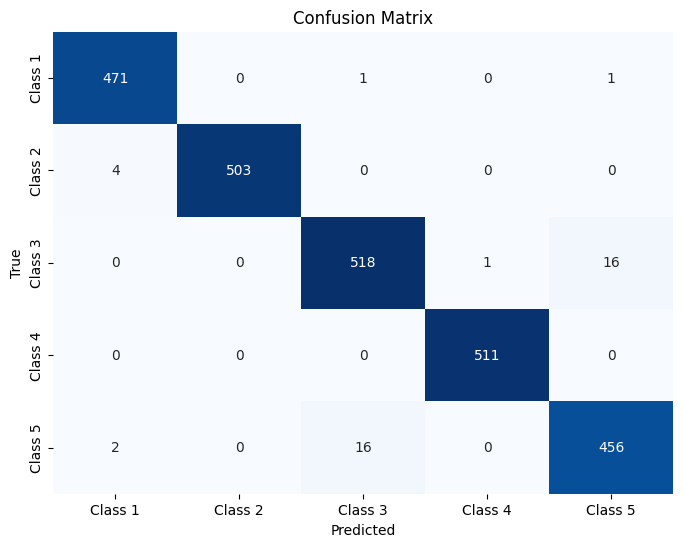

In [78]:
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False)

# Add labels and title
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

# Add class labels (if available)
class_labels = ['Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5']
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks + 0.5, class_labels)
plt.yticks(tick_marks + 0.5, class_labels)

# Show the plot
plt.show()